In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import gpytorch
from tqdm.notebook import trange
import heapq
import math
import pickle
import itertools
from utils.class_imbalance import get_classes, class_proportion

from algorithms.cgm import *

## Dataset

In [3]:
def sample_GMM(means, covs, num_samples):
    """
    Samples equally from clusters of normal distributions.
    """
    assert(means.shape[0] == covs.shape[0])
    assert(means.shape[1] == covs.shape[1])
    assert(covs.shape[1] == covs.shape[2])
    
    n = means.shape[0]
    d = means.shape[1]
    samples = np.zeros((num_samples, d))
    clusters = np.zeros(num_samples, dtype=np.int32)
    
    for i in range(num_samples):
        cluster = np.random.randint(n)
        samples[i] = np.random.multivariate_normal(means[cluster], covs[cluster], check_valid='raise')
        clusters[i] = cluster
    
    return samples, clusters

In [4]:
num_clusters = 5
d = 2
num_samples = 1000

In [5]:
np.random.seed(2)

In [6]:
means = np.random.uniform(size=(num_clusters, d))
covs = np.zeros((num_clusters, d, d))
for i in range(num_clusters):
    covs[i] = np.eye(d)/200

In [7]:
train_sets = np.zeros((num_clusters, num_samples, d))
test_sets = np.zeros((num_clusters, num_samples, d))

In [8]:
for i in range(num_clusters):
    train_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')
    test_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')

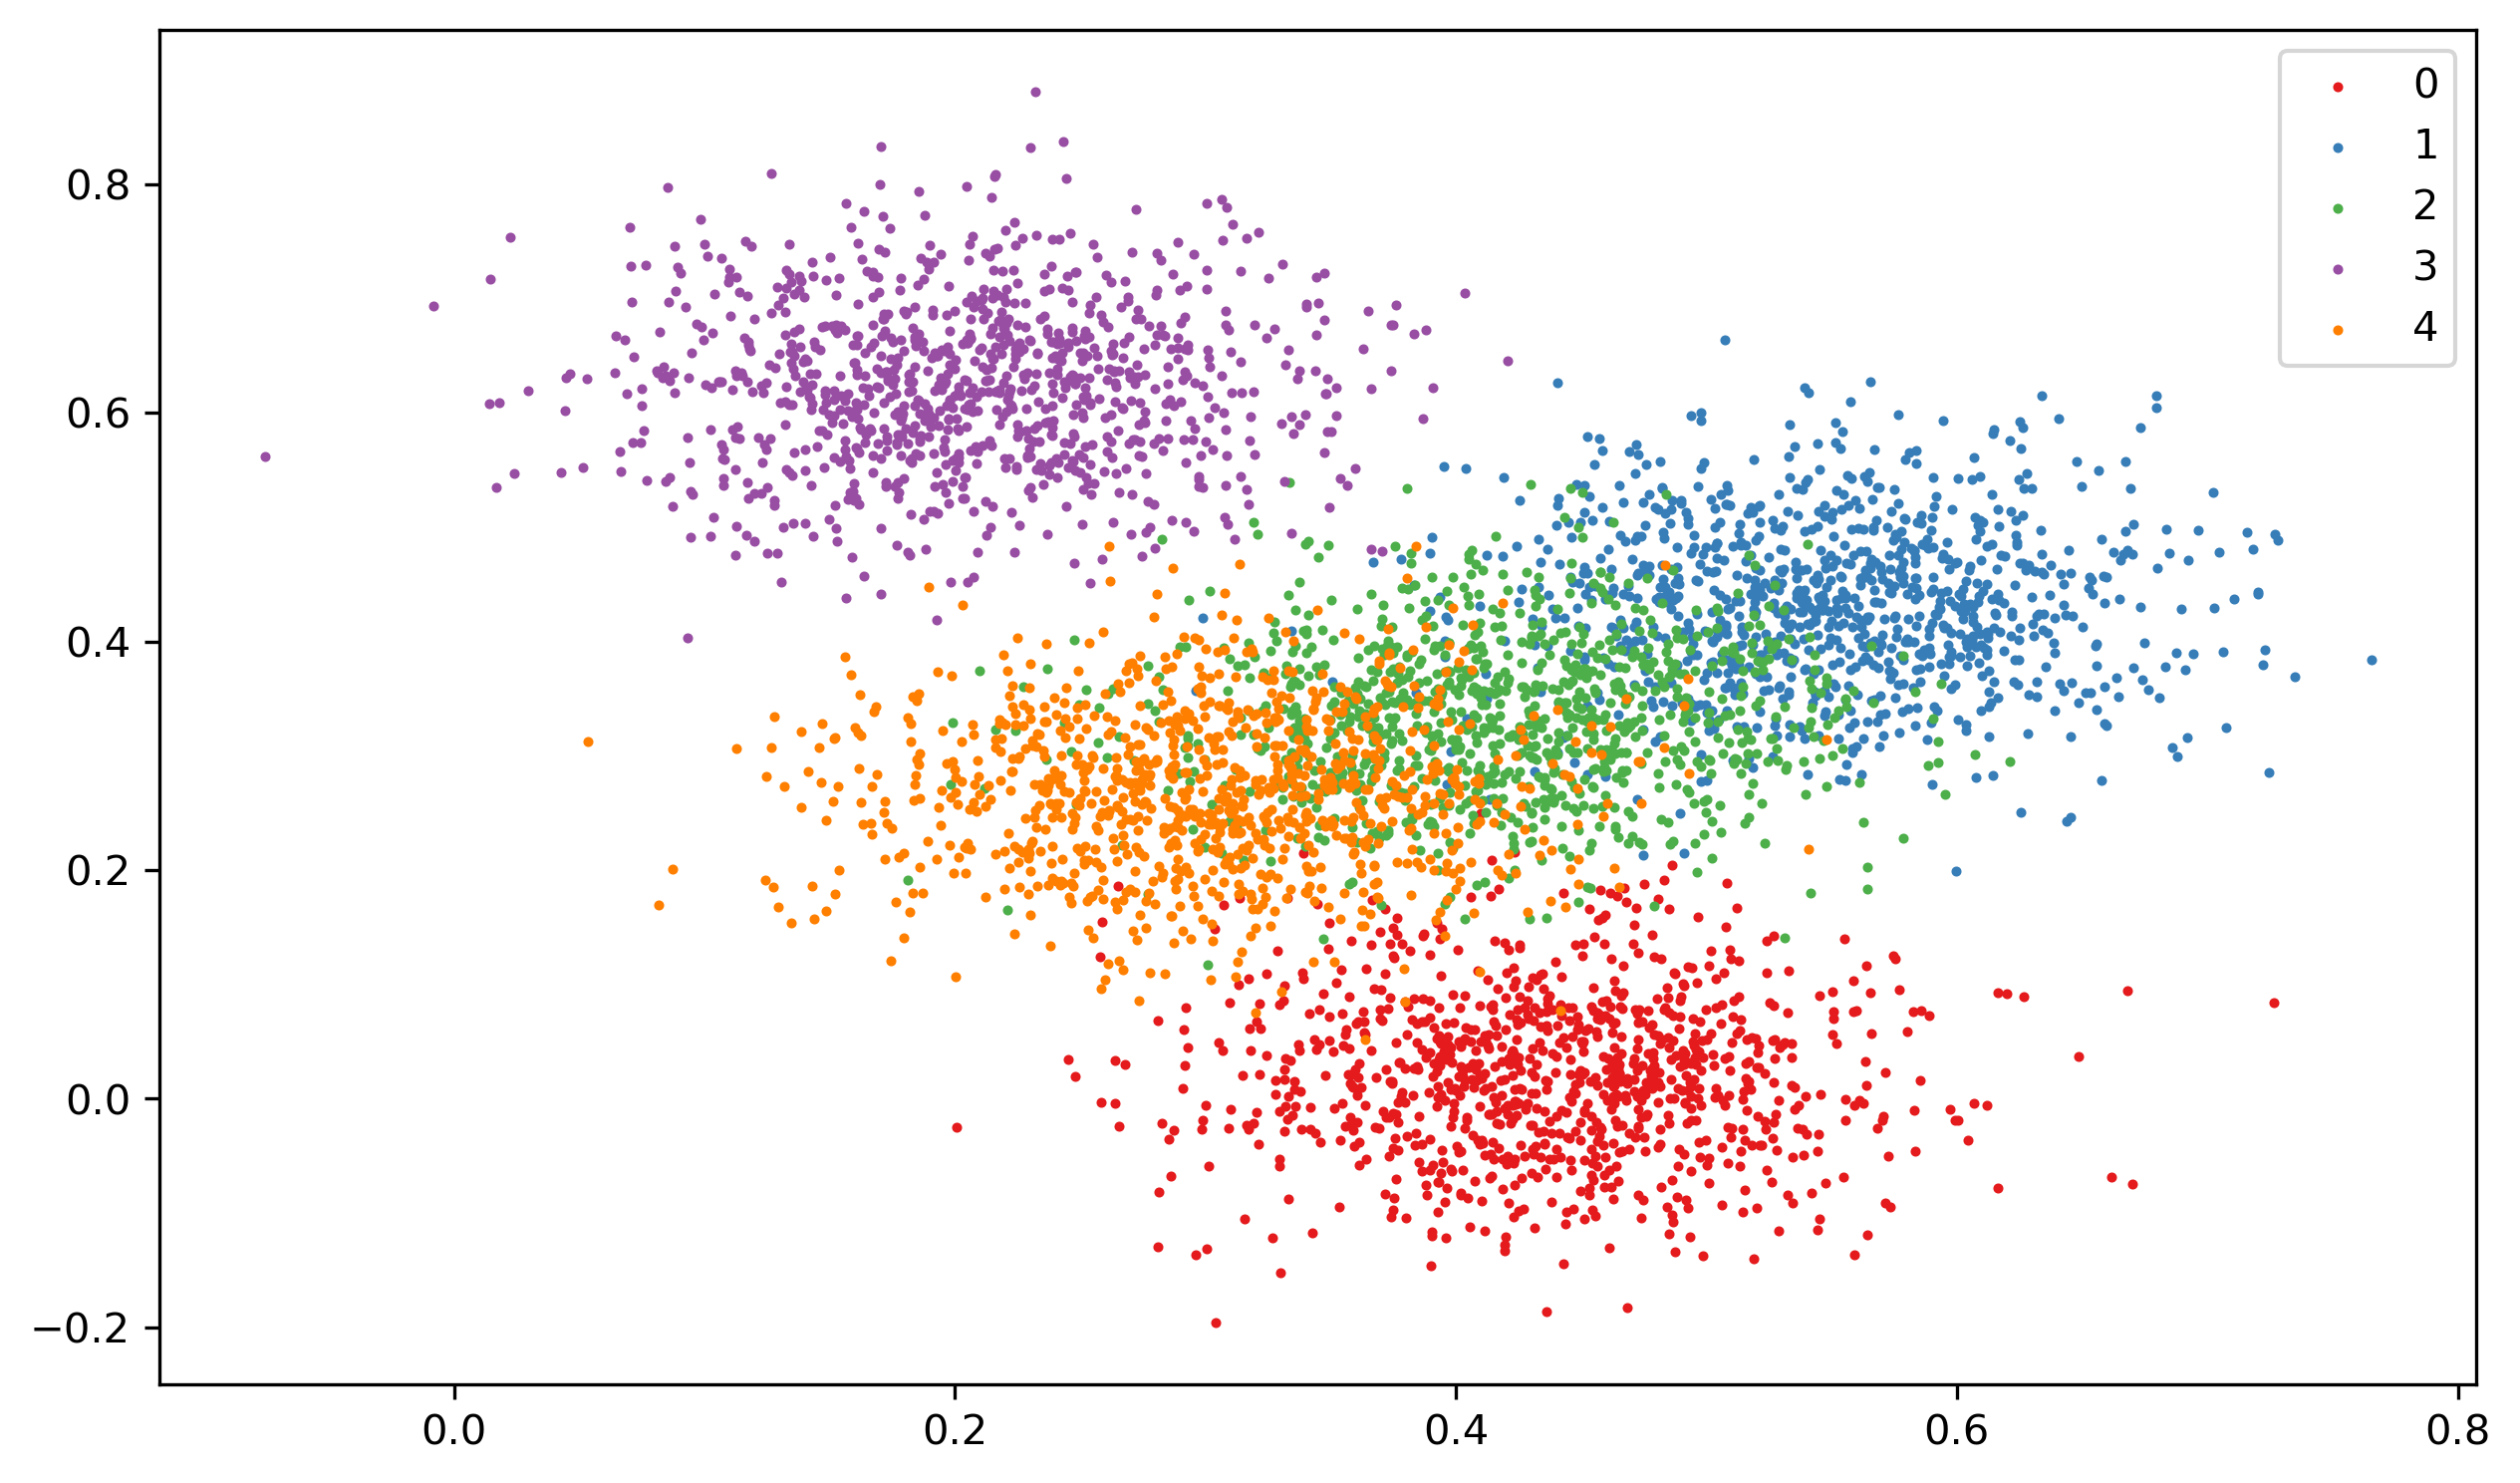

In [9]:
plt.figure(figsize=(10, 6), dpi=300)
for i in range(num_clusters):
    plt.scatter(train_sets[i, :, 0], train_sets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))
    plt.legend()

## Equal disjoint

In [10]:
num_parties = 5

In [11]:
disjoint_prop = np.eye(5)

In [12]:
party_datasets = split_proportions(train_sets, disjoint_prop)

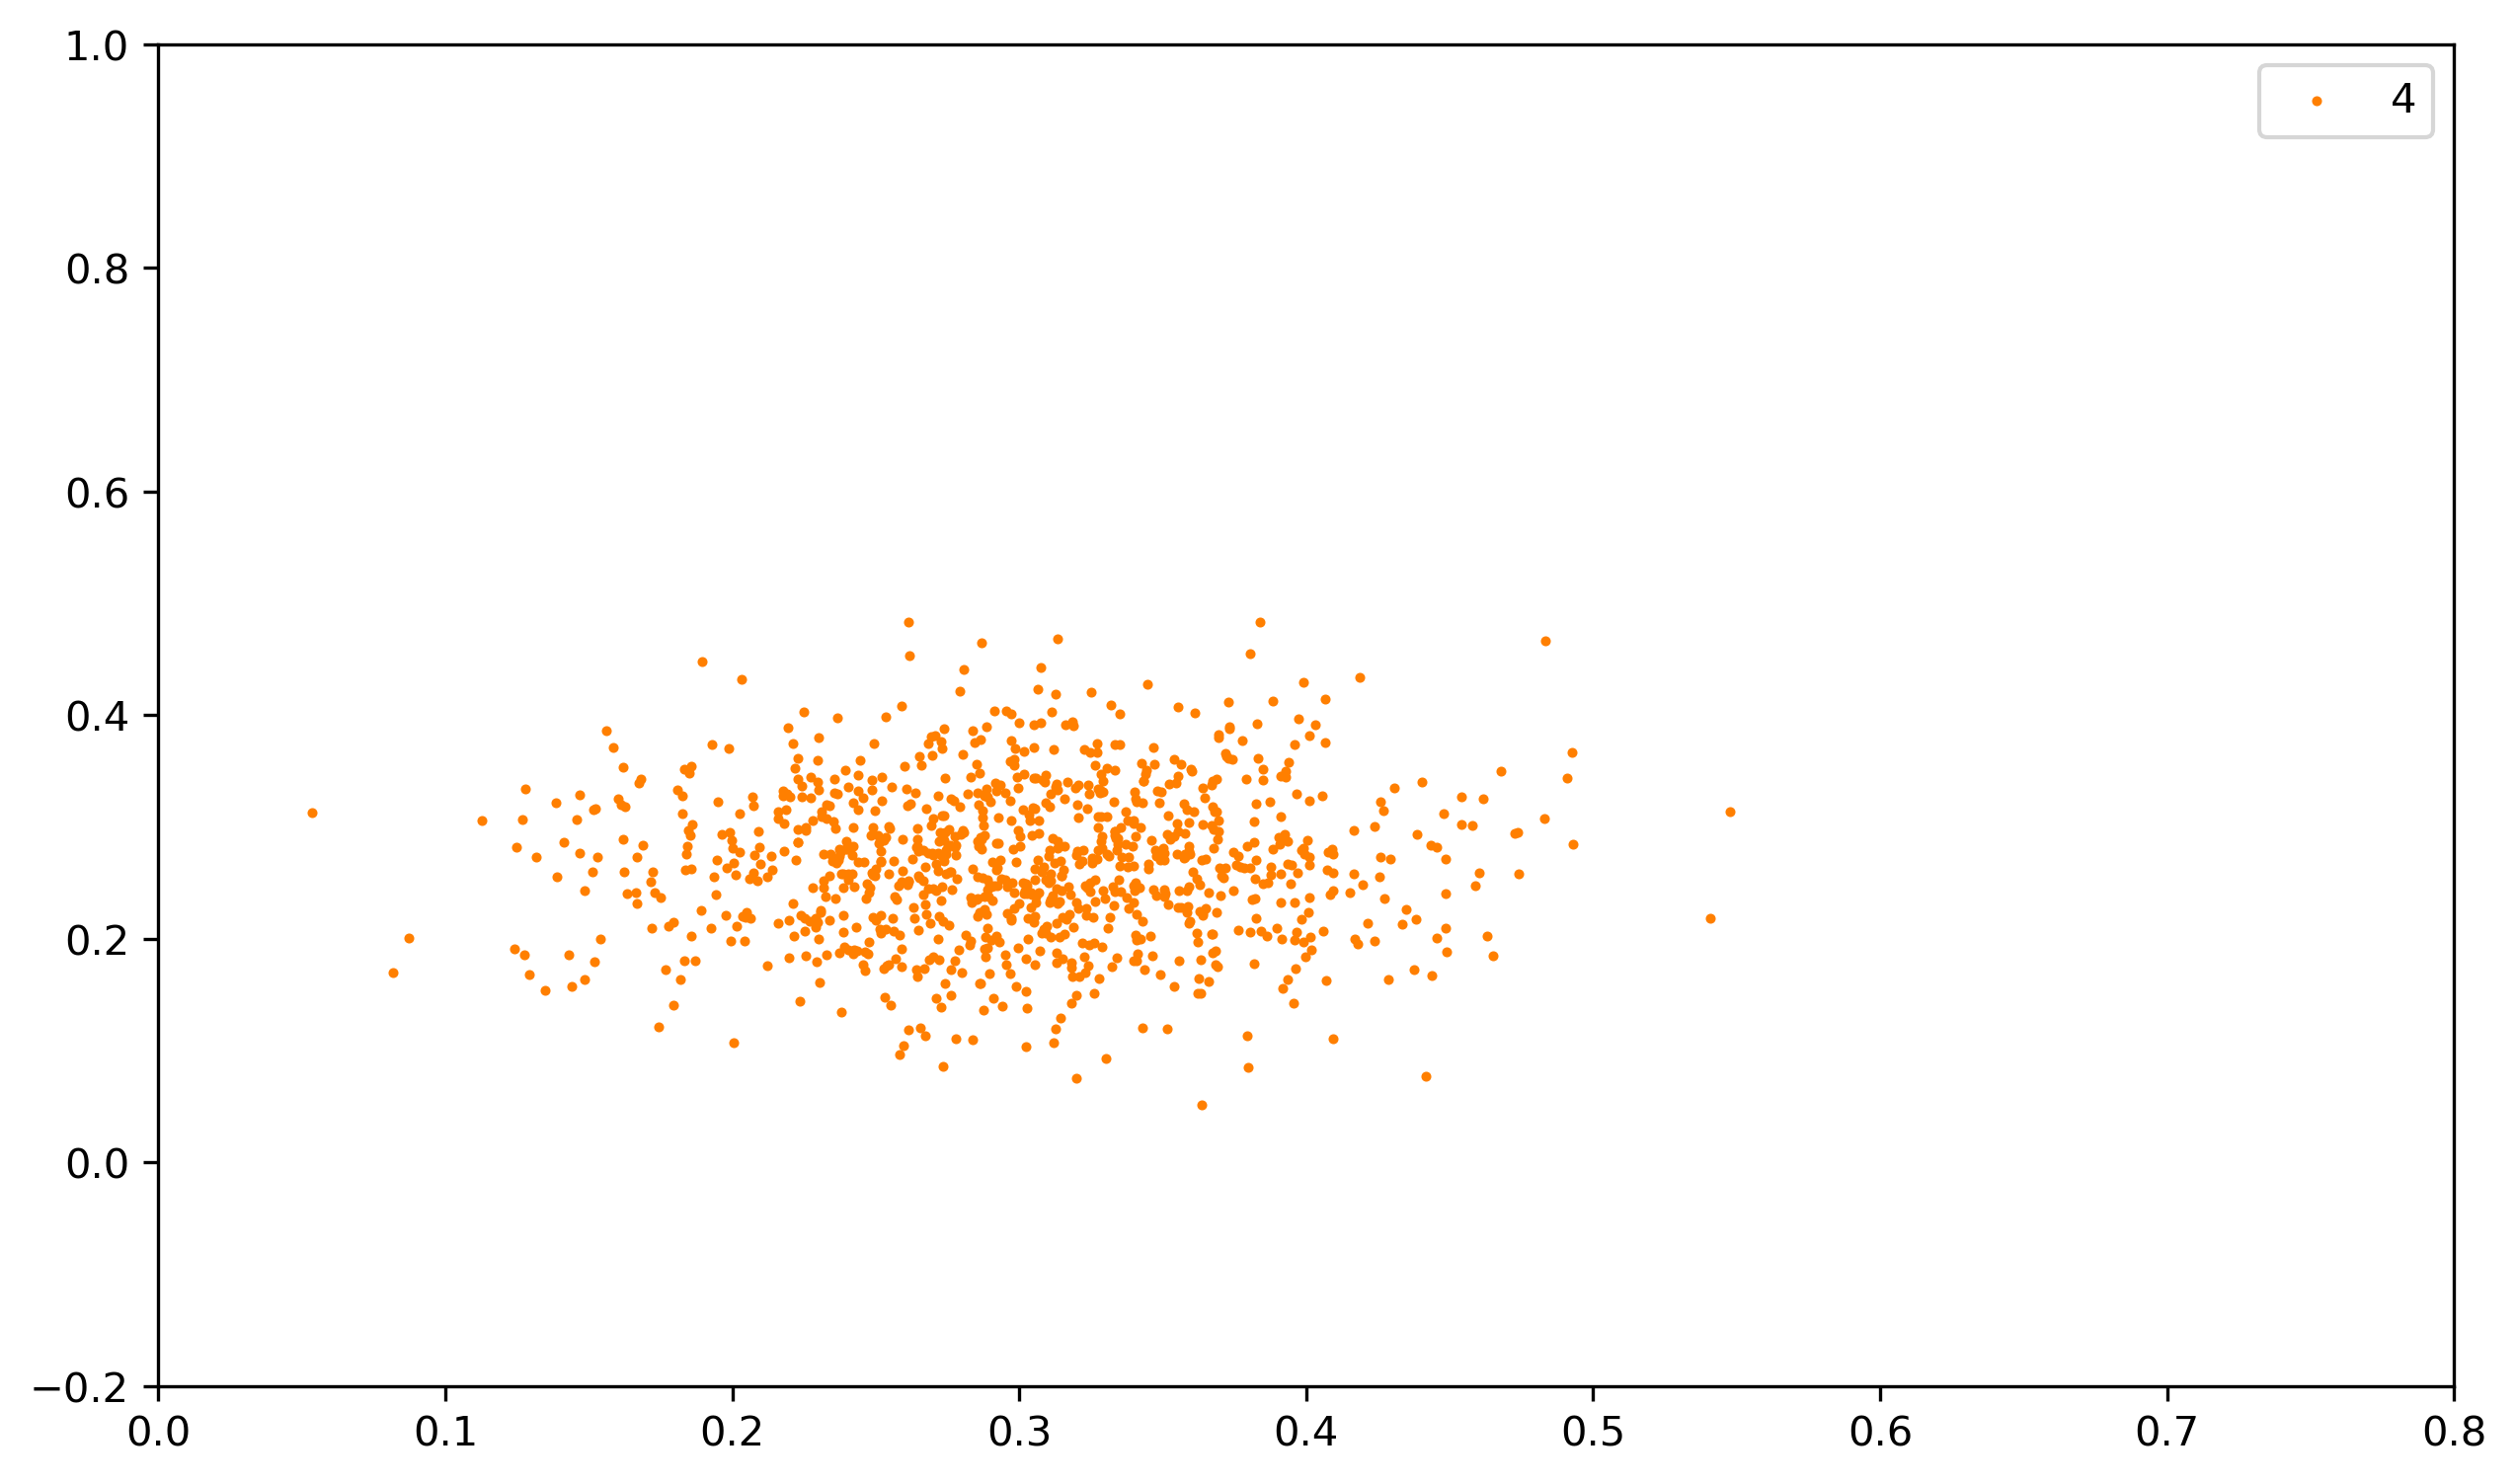

In [13]:
# Check
plt.figure(figsize=(10, 6), dpi=300)
plt.xlim(0, 0.8)
plt.ylim(-0.2, 1.0)
for i in range(num_parties):
    if i == 4:
        plt.scatter(party_datasets[i, :, 0], party_datasets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))

plt.legend()

In [14]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
kernel.base_kernel.lengthscale = [0.5, 0.5]
kernel.outputscale = 1

In [15]:
#reference_dataset, reference_labels = sample_GMM(means, covs, num_samples=5000)

In [16]:
#perm_samp_dataset, perm_samp_labels = sample_GMM(means, covs, num_samples=5000)

In [17]:
perm_samp_dataset = np.concatenate(party_datasets)

In [18]:
reference_dataset = np.concatenate(party_datasets)

In [19]:
v = get_v(party_datasets, reference_dataset, kernel)

In [20]:
v

{'{1}': 0.5147525668144226,
 '{2}': 0.6706516146659851,
 '{3}': 0.778350830078125,
 '{4}': 0.4768272638320923,
 '{5}': 0.7458575367927551,
 '{1, 2}': 0.7344838380813599,
 '{1, 3}': 0.7292967438697815,
 '{1, 4}': 0.7617717981338501,
 '{1, 5}': 0.6992271542549133,
 '{2, 3}': 0.74873286485672,
 '{2, 4}': 0.6973968744277954,
 '{2, 5}': 0.7831409573554993,
 '{3, 4}': 0.7342959046363831,
 '{3, 5}': 0.778353750705719,
 '{4, 5}': 0.7218335270881653,
 '{1, 2, 3}': 0.7651441097259521,
 '{1, 2, 4}': 0.7902641892433167,
 '{1, 2, 5}': 0.7706829905509949,
 '{1, 3, 4}': 0.7923917770385742,
 '{1, 3, 5}': 0.7542834281921387,
 '{1, 4, 5}': 0.7770993113517761,
 '{2, 3, 4}': 0.7550967931747437,
 '{2, 3, 5}': 0.7828943729400635,
 '{2, 4, 5}': 0.7684609293937683,
 '{3, 4, 5}': 0.77076655626297,
 '{1, 2, 3, 4}': 0.7964216470718384,
 '{1, 2, 3, 5}': 0.779607355594635,
 '{1, 2, 4, 5}': 0.7984524369239807,
 '{1, 3, 4, 5}': 0.7917214035987854,
 '{2, 3, 4, 5}': 0.7819775938987732,
 '{1, 2, 3, 4, 5}': 0.7997925281

In [21]:
phi = shapley(v, num_parties)
print(phi)

[0.12982105513413747, 0.16816424628098806, 0.19465282360712688, 0.12049331565697988, 0.18666108747323354]


In [22]:
alpha = norm(phi)
print(alpha)

[0.6669364087733906, 0.8639188641845676, 1.0, 0.6190165311969726, 0.9589436413723785]


In [23]:
1e-03

0.001

In [24]:
# etas = [0.001, 0.01, 0.1, 0.25, 0.5]
# all_sorted_vX = []
# for eta in etas:
#     sorted_vX = perm_sampling_neg_biased(perm_samp_dataset, reference_dataset, kernel, num_perms=200, eta=eta)
#     all_sorted_vX.append(sorted_vX)
#     print("Eta = {} - Mean:{} \\ Median:{} \\ Min: {} \\ Max: {}".format(eta, np.mean(sorted_vX), np.median(sorted_vX), np.min(sorted_vX), np.max(sorted_vX)))

In [25]:
# all_sorted_vX_variant = []
# for eta in etas:
#     sorted_vX = perm_sampling_neg_biased_variant(perm_samp_dataset, reference_dataset, kernel, num_perms=200, eta=eta)
#     all_sorted_vX_variant.append(sorted_vX)
#     print("Eta = {} - Mean:{} \\ Median:{} \\ Min: {} \\ Max: {}".format(eta, np.mean(sorted_vX), np.median(sorted_vX), np.min(sorted_vX), np.max(sorted_vX)))

In [26]:
vN = get_vN(v, num_parties)
print(vN)

0.7997925281524658


In [27]:
v_is = get_v_is(v, num_parties)
print(v_is)

[0.5147525668144226, 0.6706516146659851, 0.778350830078125, 0.4768272638320923, 0.7458575367927551]


## R6

In [28]:
q, rho = get_q_rho(alpha, v_is, vN, phi, v, cond="R6")

In [29]:
rho

0.040000832853652225

In [30]:
v_is

[0.5147525668144226,
 0.6706516146659851,
 0.778350830078125,
 0.4768272638320923,
 0.7458575367927551]

In [31]:
#all condition
r = list(map(q, alpha))
print(r)

[0.7869381012478254, 0.7951264634504162, 0.7997925281524658, 0.7845944991716685, 0.7984524369239807]


In [32]:
num_candidate_points = 8000
gmm_clusters = [sample_GMM(means, covs, num_candidate_points) for i in range(num_clusters)]
gmm = np.array([pair[0] for pair in gmm_clusters])
clusters = np.array([pair[1] for pair in gmm_clusters])
cand_datasets = np.array([gmm[0]]*num_parties)

In [33]:
greeds = np.ones(num_parties) * 3

In [34]:
rewards, deltas, mus = reward_realization(cand_datasets, 
                                          reference_dataset, 
                                          r, 
                                          party_datasets, 
                                          kernel, 
                                          greeds=greeds,
                                          rel_tol=1e-5)

Running weighted sampling algorithm with -MMD^2 target 0.7869381012478254
Running weighted sampling algorithm with -MMD^2 target 0.7951264634504162Running weighted sampling algorithm with -MMD^2 target 0.7997925281524658
Running weighted sampling algorithm with -MMD^2 target 0.7845944991716685

Running weighted sampling algorithm with -MMD^2 target 0.7984524369239807


In [35]:
x = np.array([0.1])

In [36]:
x

array([0.1])

In [37]:
len(np.delete(x, 0))

0

In [38]:
pickle.dump((gmm, clusters, reference_dataset, cand_datasets, party_datasets, greeds, rewards, deltas, mus), open("results/CGM-GMM-rho-equaldisjoint-greed3-stable.p", "wb"))

In [39]:
class_props = []
for result in rewards:
        class_props.append(class_proportion(get_classes(np.array(result), gmm[0], clusters[0]), num_clusters))

In [40]:
class_props

[(array([0.04065041, 0.22831978, 0.20121951, 0.36653117, 0.16327913]),
  0.05105536827726001),
 (array([0.27435159, 0.07608069, 0.14466859, 0.23112392, 0.27377522]),
  0.046071439842536685),
 (array([0.26289723, 0.1828312 , 0.11432109, 0.27404045, 0.16591003]),
  0.0436471638474933),
 (array([0.34484965, 0.19641715, 0.20793346, 0.04670505, 0.20409469]),
  0.048914660808221475),
 (array([0.19323671, 0.30736715, 0.16123188, 0.24094203, 0.09722222]),
  0.04506318700553105)]

In [41]:
for i in range(num_parties):
    print(mmd_neg_biased(np.concatenate([party_datasets[i], np.array(rewards[i])], axis=0), reference_dataset, kernel)[0])

0.7869582176208496
0.7951271533966064
0.7997846007347107
0.7845983505249023
0.7984471321105957
